# Getting Started

This section sets up the environment for access to the Universal Sentence Encoder on TF Hub and provides examples of applying the encoder to words, sentences, and paragraphs.
Tutorial followed:
https://www.dlology.com/blog/keras-meets-universal-sentence-encoder-transfer-learning-for-text-data/

In [1]:
# Install the latest Tensorflow version.
!pip3 install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip3 install --quiet tensorflow-hub
!pip3 install seaborn

More detailed information about installing Tensorflow can be found at [https://www.tensorflow.org/install/](https://www.tensorflow.org/install/).

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import keras.layers as layers
from keras.models import Model
from keras import backend as K
np.random.seed(10)

W0513 09:12:56.696139 140177703028608 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
Using TensorFlow backend.


In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]

In [4]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module(module_url)


Instructions for updating:
Colocations handled automatically by placer.


W0513 09:12:58.129595 140177703028608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [5]:
embed_size = embed.get_output_info_dict()['default'].get_shape()[1].value
embed_size

512

In [6]:
df=pd.read_csv("labeled_data.csv")

df_train=df[['class', 'tweet']]
# df.class = df.class.astype('category')
df_train.loc[df_train['class'] == 2, 'class'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
df_train.columns = ["label","text"]

In [8]:
df_train.head()

,label,text
0,1,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [9]:
df_train.label = df_train.label.astype('category')


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [10]:
category_counts = len(df_train.label.cat.categories)
category_counts

2

In [0]:
def UniversalEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [12]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = layers.Lambda(UniversalEmbedding, output_shape=(embed_size,))(input_text)
dense = layers.Dense(256, activation='relu')(embedding)
pred = layers.Dense(category_counts, activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0513 09:13:47.110457 140177703028608 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 131,842
Trainable params: 131,842
Non-trainable params: 0
_________________________________________________________________


In [0]:
hate=df_train[df_train.label==0]
offensive=df_train[df_train.label==1]

In [0]:
hate=hate.sample(frac=1)
offensive=offensive=offensive.sample(frac=1)


In [0]:
new_hate=hate[:min(len(hate), len(offensive))]
new_off=offensive[:min(len(hate), len(offensive))]


In [0]:
new_hate = new_hate.append(new_off)
df_train=new_hate

In [0]:
train_text = df_train['text'].tolist()
train_text = np.array(train_text, dtype=object)[:, np.newaxis]

train_label = np.asarray(pd.get_dummies(df_train.label), dtype = np.int8)

In [18]:
train_text.shape

(2860, 1)

In [19]:
train_label.shape

(2860, 2)

## Train Keras model and save weights
This only train and save our Keras layers not the embed module' weights.

In [21]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  history = model.fit(train_text, 
            train_label,
            validation_split=0.2,
            epochs=15,
            batch_size=32)
  model.save_weights('./model.h5')

Train on 2288 samples, validate on 572 samples
Epoch 1/15
  96/2288 [>.............................] - ETA: 23s - loss: 0.6691 - acc: 0.6146 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f7d1e7a1fd0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


2240/2288 [============================>.] - ETA: 0s - loss: 0.4946 - acc: 0.7433

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f7d1e7ba9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


2288/2288 [==============================] - 4s 2ms/step - loss: 0.4926 - acc: 0.7448 - val_loss: 0.6258 - val_acc: 0.7255
Epoch 2/15
2288/2288 [==============================] - 2s 1ms/step - loss: 0.4047 - acc: 0.8129 - val_loss: 0.6695 - val_acc: 0.6766
Epoch 3/15
2288/2288 [==============================] - 2s 1ms/step - loss: 0.3891 - acc: 0.8239 - val_loss: 0.6470 - val_acc: 0.6923
Epoch 4/15
2288/2288 [==============================] - 2s 929us/step - loss: 0.3751 - acc: 0.8330 - val_loss: 0.6552 - val_acc: 0.6871
Epoch 5/15
2288/2288 [==============================] - 2s 926us/step - loss: 0.3623 - acc: 0.8405 - val_loss: 0.6202 - val_acc: 0.7185
Epoch 6/15
2288/2288 [==============================] - 2s 920us/step - loss: 0.3506 - acc: 0.8523 - val_loss: 0.5872 - val_acc: 0.7448
Epoch 7/15
2288/2288 [==============================] - 2s 945us/step - loss: 0.3364 - acc: 0.8549 - val_loss: 0.6078 - val_acc: 0.7378
Epoch 8/15
2288/2288 [==============================] - 2s 925us/

## Make predictions

In [0]:
# new_text = list(s.comments)
# new_text = np.array(new_text, dtype=object)[:, np.newaxis]
new_text=train_text
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights('./model.h5')  
  predicts = model.predict(new_text, batch_size=32)

In [23]:
categories = df_train.label.cat.categories.tolist()
predict_logits = predicts.argmax(axis=1)
predict_labels = [categories[logit] for logit in predict_logits]
predict_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [24]:
df_train.label

10929    0
731      0
15654    0
6487     0
5362     0
14198    0
17757    0
23325    0
2704     0
6348     0
5513     0
18038    0
3006     0
13413    0
12254    0
2521     0
13722    0
20266    0
6454     0
6683     0
18676    0
15269    0
5580     0
11681    0
3902     0
9066     0
14591    0
2472     0
19351    0
7029     0
        ..
6959     1
23262    1
4823     1
16316    1
8670     1
19907    1
19328    1
6795     1
17000    1
606      1
16066    1
23951    1
12734    1
16608    1
9583     1
23466    1
9601     1
17598    1
20461    1
14899    1
3030     1
11003    1
21150    1
14061    1
14112    1
8654     1
5911     1
5391     1
2787     1
14194    1
Name: label, Length: 2860, dtype: category
Categories (2, int64): [0, 1]

In [25]:
tf.confusion_matrix(df_train.label, predict_labels)

Instructions for updating:
Use tf.cast instead.


W0513 09:16:08.399286 140177703028608 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/confusion_matrix.py:193: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


<tf.Tensor 'confusion_matrix/SparseTensorDenseAdd:0' shape=(2, 2) dtype=int32>

In [0]:
from sklearn.metrics import classification_report
report = classification_report(df_train.label, predict_labels)

In [27]:
print(report)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      1430
           1       0.94      0.84      0.89      1430

   micro avg       0.89      0.89      0.89      2860
   macro avg       0.90      0.89      0.89      2860
weighted avg       0.90      0.89      0.89      2860



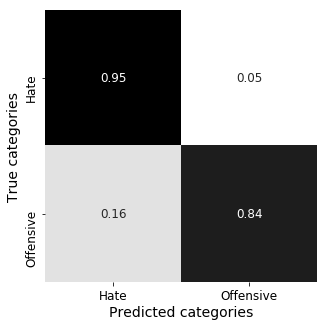

In [30]:
import seaborn
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(df_train.label, predict_labels)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)